# A/B–тестирование и автоматизация расчёта метрик и построения графиков
## Проект выполнен в рамказ прохождения курса аналитики данных Karpov.courses

## Задание 1. A/B–тестирование

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from scipy import stats
import pingouin as pg
import json
import requests
from urllib.parse import urlencode
import csv

### Загрузка данных

#### Используемые данные:
 - groups.csv —  информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) — https://disk.yandex.ru/d/UhyYx41rTt3clQ
 - groups_add.csv — дополнительный файл с распределением пользователей по группам — https://disk.yandex.ru/d/5Kxrz02m3IBUwQ
 - active_studs.csv — информацией о пользователях, которые зашли на платформу в дни проведения эксперимента — https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ
 - checks.csv  — файл с информацией об оплатах пользователей в дни проведения эксперимента — https://disk.yandex.ru/d/pH1q-VqcxXjsVA

In [ ]:
# Пишу функцию для загрузки данных через API
def data_load(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    response = requests.get(download_url)
    return download_url

In [ ]:
# Получаю прямую ссылку на скачивание для всех файлов
groups1_url = data_load('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
groups2_url = data_load('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
active_url  = data_load('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
checks_url  = data_load('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [ ]:
groups1 = pd.read_csv(groups1_url, sep=';')
groups2 = pd.read_csv(groups2_url)
active  = pd.read_csv(active_url)
checks  = pd.read_csv(checks_url, sep=';')

### Предобработка данных

Пред тем как провести исследование, ознакомимся с данными. Посмотрим на число столбцов, типы данных, наличие пропущенных значений, проверим данные на присутствие дубликатов.

In [ ]:
groups1.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [ ]:
groups1.shape[0]

74484

In [ ]:
groups1.isna().sum()

id     0
grp    0
dtype: int64

In [ ]:
groups1.duplicated().sum()

0

In [ ]:
groups2.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [ ]:
groups2.shape[0]

92

In [ ]:
groups2.isna().sum()

id     0
grp    0
dtype: int64

In [ ]:
groups2.duplicated().sum()

0

In [ ]:
# Объеденим данные по группам
groups = pd.concat([groups1, groups2], ignore_index=True)

In [ ]:
# Получили полный список
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [ ]:
# Проверим формат данных
groups.dtypes

id      int64
grp    object
dtype: object

In [ ]:
# Изменим формат, чтобы вдальнейшем тип данных "object" не мешал работе агрегационных функций
groups.grp = groups.grp.astype(str)

In [ ]:
# Проверим
groups.grp.apply(type).value_counts()

<class 'str'>    74576
Name: grp, dtype: int64

In [ ]:
groups.shape[0]

74576

In [ ]:
# проверили, что количество сохранилось
groups1.shape[0] + groups2.shape[0]

74576

In [ ]:
# также проверим не возникло ли дубликатов
groups.duplicated().sum()

0

In [ ]:
active.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [ ]:
active.shape[0]

8341

In [ ]:
active.isna().sum()

student_id    0
dtype: int64

In [ ]:
active.duplicated().sum()

0

In [ ]:
active = active.rename(columns = {'student_id':'id'})

In [ ]:
checks.tail(3)

,student_id,rev
538,5662322,1900.0
539,5681918,1900.0
540,5740903,1900.0


In [ ]:
checks.duplicated().sum()

0

In [ ]:
# Здесь обратим внимание, что был произведен 541 платеж
checks.shape[0]

541

In [ ]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [ ]:
checks = checks.rename(columns = {'student_id':'id'})

In [ ]:
# Посмотрим разброс стоимости покупок

In [ ]:
checks.rev.min()

199.0

In [ ]:
checks.rev.max()

4650.0

#### Теперь создадим сводную таблцу с результатами тестирования

In [ ]:
test = active.merge(checks, how ='left',  on='id')\
             .merge(groups, how ='inner', on='id')\
             .fillna(value=0)

In [ ]:
# Добавляю колонку, чтобы ометить, совершал ли конкретный активный пользователь покупку.
test['purchase'] = np.where(test['rev'] > 0, 1, 0)

In [ ]:
test.shape[0]

8341

In [ ]:
test.dtypes

id            int64
rev         float64
grp          object
purchase      int64
dtype: object

In [ ]:
test.tail(5)

,id,rev,grp,purchase
8336,1794344,0.0,B,0
8337,296883,0.0,B,0
8338,3598448,0.0,B,0
8339,3610547,290.0,B,1
8340,205705,0.0,B,0


In [ ]:
# Посмотрим, сколько было посетителей платформы в каждой группе, и сколько из них совершили покупку
test.groupby('grp', as_index=False)\
    .agg({'purchase':['count', 'sum'] })\
    .pipe(lambda x: x.set_axis(x.columns.map('_'.join), axis=1))\
    .rename(columns = {'grp_':'grp', 'purchase_count':'visitors', 'purchase_sum':'purchase'})

,grp,visitors,purchase
0,A,1538,78
1,B,6803,314


Исходя из данных выше, получается, что было совершено 392 (78 + 314) покупки, но в таблице checks мы зафиксировали 541 запись о покупке.

In [ ]:
# Каждому покупателю из таблицы checks была присвоена группа (ниже, проверяем, что нет пропусков в столбце групп)
checks.merge(groups, how ='left',  on='id').grp.isna().sum()

0

In [ ]:
# И таких покупателей, с присвоенной группой было 541
checks.merge(groups, how ='left',  on='id').shape[0]

541

In [ ]:
active.merge(checks, how ='left',  on='id').rev.notna().sum()
# При этом, в активных пользователях только 392 из 541 покупателя.
# Ещё 149 покупателей не попали в список активных пользователей.

392

In [ ]:
# Исключаю проблему с форматами
test.grp.apply(type).value_counts()

<class 'str'>    8341
Name: grp, dtype: int64

In [ ]:
# Проверяю есть ли повторные покупки в файле с id
checks.id.nunique()
# Нет, все id уникальны

541

#### Буду считать, что если пользователю была присвоена группа, и он совершил покупку на платформе по одной и двух исследуемых механик, значит он стал участником нашего тестирования, и такой пользователь будет считаться активным. Поэтому добавлю id всех покупателей в список активных пользователей.

In [ ]:
test_full = checks.merge(active, on='id', how='outer')\
                  .merge(groups, how ='inner', on='id')\
                  .fillna(value=0)

In [ ]:
# Тут повторюсь, что создаю колонку с отметкой о покупке.
#  1 — пользователь совершил покупку, 0 —  не совершал.
test_full['purchase'] = np.where(test_full['rev'] > 0, 1, 0)

In [ ]:
test_full.head()

,id,rev,grp,purchase
0,1627,990.0,A,1
1,3185,690.0,B,1
2,25973,690.0,B,1
3,26280,690.0,B,1
4,100300,990.0,B,1


### Выбор метрик для оценки теста

В данном исследовании будем сравнивать следующие метрики:
 - конверсия в покупку (CR - Convertion Rate), важнейший показатель в e-commerce, который зависит от множества факторов, в частности, от технической стороны и доступных платёжных сервисов;
 - средний чек, который в нашем случае (когда платящий совершает покупает подписку единственный раз) будет равен ARPPU (Average Revenue Per Paying User) — выручке на платящих пользователей.

 Отметим, что ниже, мы считаем именно средний чек, т.е. считаем его как доход/количество покупок, если длительность эксперимента превысит длительность минимальной подписки, то счиатать ARPPU надо будет по-другому, как доход/количество покупателей. Также мы могли бы расчитать и ARPU,  но в данном конкретном случае, когда мы тестируем платёжную систему, нас в первую очередь интересуют те пользователи, которые совершили покупку.

### Исследование изменения конверсии в покупку

 - H0 : Новая механика оплаты не влияет на конверсию в покупку;
 - H1 : Новая механика оплаты влияет на конверсию в покупку.

 Оценивая конверсию, мы имеем дело с категориальным переменными (контрольная группа/тестовая грауппа, покупка/отсутствие покупки), поэтому теста будем использовать метод хи-квадрат. Мы можем его использовать поскольку наблюдения независимы и их количество больше 10.

In [ ]:
test_metrics = test_full.groupby('grp', as_index=False)\
                        .agg({'purchase':['count', 'sum'] })\
                        .pipe(lambda x: x.set_axis(x.columns.map(''.join), axis=1))\
                        .rename(columns = {'purchasecount':'visitors', 'purchasesum':'purchase'})

test_metrics['CR'] = round(100*test_metrics['purchase']/test_metrics['visitors'], 2)

In [ ]:
test_metrics

,grp,visitors,purchase,CR
0,A,1567,107,6.83
1,B,6923,434,6.27


In [ ]:
 print('Conversion Rate в тестовой группе ниже на %.1f процента. Проверим, является ли это различие статистически-значимым.' % (100 - 100*6.27/6.83)  )

Conversion Rate в тестовой группе ниже на 8.2 процента. Проверим, является ли это различие статистически-значимым.


In [ ]:
exp, obs, stats  = pg.chi2_independence(data=test_full, x='grp', y='purchase')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.579666,1.0,0.446443,0.008263,0.118592
1,cressie-read,0.666667,0.576646,1.0,0.447630,0.008241,0.118225
2,log-likelihood,0.000000,0.570710,1.0,0.449977,0.008199,0.117506
3,freeman-tukey,-0.500000,0.566347,1.0,0.451714,0.008167,0.116977
4,mod-log-likelihood,-1.000000,0.562060,1.0,0.453432,0.008136,0.116458
5,neyman,-2.000000,0.553705,1.0,0.456808,0.008076,0.115446


#### Вывод по тесту Хи-квадрат:
 Вне зависимости от того, какой именно тип теста значимости хи-квадрат мы используем все p-value сильно больше 0,05. Это указывает на то, что мы не можем отклонить нулевую гипотезу и принять альтернативную. Разница в конверсии между группами не так велика, чтобы признать её статистически значимой.

#### Таким образом на основании теста хи-квадрат мы не можем отвергнуть нулевую гипотезу

###  Оценим различие средней суммы чека внутри групп

#### Для определения среднего чека
 - H0 : Новая механика оплаты не влияет на размер среднего чека;
 - H1 : Новый механика оплаты влияет на размер среднего чека.

In [ ]:
test_metrics['common_rev'] = test_full.groupby('grp', as_index=False)\
                                      .agg({'rev': 'sum' })\
                                      .rev.round()

test_metrics['avg_check'] = round(test_metrics['common_rev']/test_metrics['purchase'])
test_metrics['avg_check'] = test_metrics['avg_check'].astype(int)

In [ ]:
test_metrics

,grp,visitors,purchase,CR,common_rev,avg_check
0,A,1567,107,6.83,92096.0,861
1,B,6923,434,6.27,481230.0,1109


In [ ]:
print('avg_check в тестовой группе выше на %.1f процента. Проверим, является ли это различие статистически-значимым.' % (100*1109.0/861.0 - 100))

avg_check в тестовой группе выше на 28.8 процента. Проверим, является ли это различие статистически-значимым.


In [ ]:
avg_check = test_full.query('purchase==1')

In [ ]:
# Проверим данные на нормальность
control_check = avg_check.query('grp=="A"')
test_check    = avg_check.query('grp=="B"')

In [ ]:
pg.normality(control_check['rev'])

,W,pval,normal
rev,0.719612,5.321688e-13,False


In [ ]:
pg.normality(test_check['rev'])

,W,pval,normal
rev,0.867236,8.947893e-19,False


Text(0.5, 1.0, 'Распределение суммы чека внутри групп')

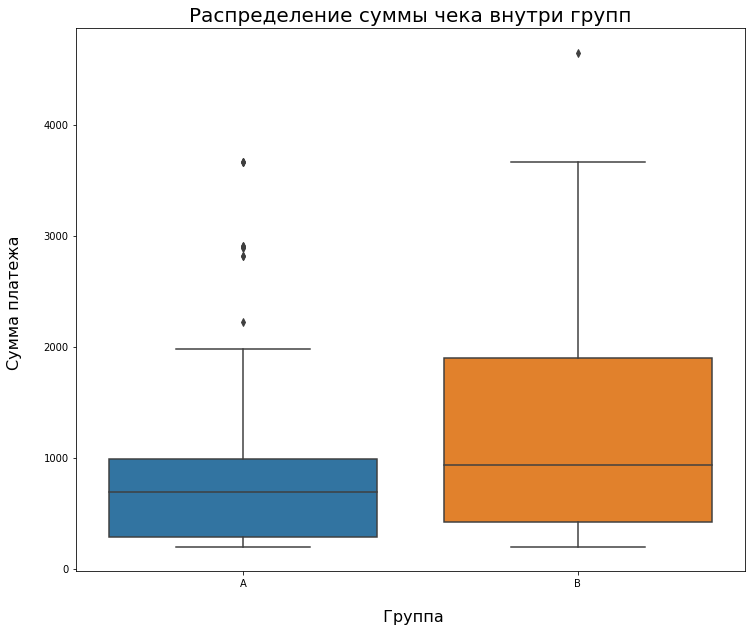

In [ ]:
# Визуализируем разброс по сумме заказов
plt.rcParams['figure.figsize'] = [12, 10]
sns.boxplot(data = avg_check, x='grp', y='rev')
plt.ylabel('Сумма платежа \n', size=16)
plt.xlabel('\n Группа',       size=16)
plt.title('Распределение суммы чека внутри групп',  size=20)

Распределение сумм заказов ненормальное, в контрольной группе имеется большое количество выбросов. На графике видим, что квартили распределений пересекаются. Однако, вид графика вселяет надежду, на перспективность новой механики оплаты.
#### Для получения более точного измеримого результата будем сравнивать средние значения методом бутстрап.

In [ ]:
Nboot = 10000  # Установим количество выборок 10 000
x = avg_check.query('grp=="A"')['rev'].to_numpy()
y = avg_check.query('grp=="B"')['rev'].to_numpy()

In [ ]:
ci, dist = pg.compute_bootci(
    x,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[ 718.42 1027.24]


In [ ]:
ci, dist = pg.compute_bootci(
    y,
    func='mean',
    confidence=0.95,
    n_boot=Nboot,
    paired=False,
    return_dist=True
)
print(ci)

[1040.45 1179.53]


In [ ]:
ci, dist = pg.compute_bootci(
    x,
    y,
    func=lambda x, y: np.mean(x) - np.mean(y),
    confidence=0.95,
    n_boot=Nboot,
    return_dist=True
)
print(ci)

[-524.78 -155.53]


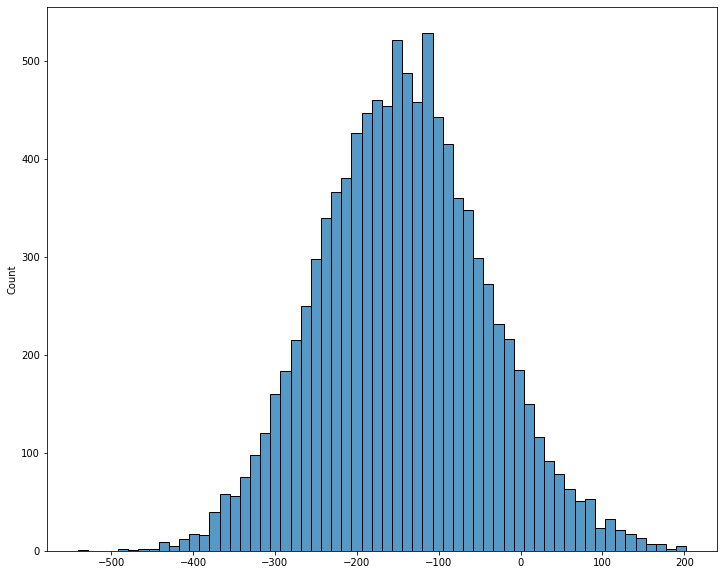

In [ ]:
sns.histplot(dist)

#### Выводы по сравнению средних чеков
 1. Можем отклонить нулевую гипотезу. Средний чек пользователей статистически значимо различается в тестовой и контрольной группах, 95-процентные доверительные интервалы не пересекаются.
 2. В тестовой группе в средний чек выше, чем в контрольной.

### Выводы по A/B тесту
#### Исследование показало , что мы не можем говорить о влияние изменения механики оплаты на конверсию в покупку. При этом изменение механики благоприятно повлияло на размер среднего чека. В эксперименте, в тестовой группе средняя стоимость покупки возрасла на 29% по сравнению с контрольной группой. Различия в сумме среднего чека является статистически значимым. Поэтому рекомендую запустить новую механику.

#### Новая механика, вероятно, несёт некоторые выгоды для покупателя (бонусы/ кэшбек банка/ отсутствие страха того, что деньги "застрянут" / отстутствие коммиссии за платёж, возможность оперировать большей суммой/ возможность расплатиться в кредит или рассрочку.

## Задание 2. Автоматизация расчётаметрик и построения графиков

### 2.1 Реализация функции для автоматического обновления расчёта метрик на основе дополнительного файла groups_add.csv

Поскольку функция должна работать автоматически, воспользуемся загрузкой дополнительной таблицы groups_add.csv с яндекс диска

In [ ]:
# Функция принимает на вход акуальную ссылку на дополнительный файл с яндекс диска в виде строки
def metrics(public_key):
    # Подключаемся к яндекс диску
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # запрашиваем url для скачивания через public_key
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)

    # через элемент href в json получаем url
    download_url = response.json()['href']
    response = requests.get(download_url)
    groups_addition = pd.read_csv(download_url, sep=',')

    groups_addition.columns = groups1.columns
    groups_renewed = pd.concat([groups1, groups_addition], axis=0, ignore_index=True)

    # На всякий случай позаботимся о дубликатах, пустых полях и формате
    groups_renewed.drop_duplicates(inplace=True)
    groups_renewed.dropna(inplace=True)
    groups_renewed = groups_renewed.grp.astype(str)

    # Далее датафреймы, создаём результирующую таблицу и считаем метрики
    # Переменную test_sum, в которой будет датафрейм с метриками объявляю глобальной, чтобы потом построить по ней графики
    global test_sum
    test_sum = checks.merge(active, on='id', how='outer')\
                     .merge(groups, how ='inner', on='id')\
                     .fillna(value=0)

    test_sum['purchase'] = np.where(test_full['rev'] > 0, 1, 0)

    test_sum = test_sum.groupby('grp', as_index=False)\
                            .agg({'purchase':['count', 'sum'] })\
                            .pipe(lambda x: x.set_axis(x.columns.map(''.join), axis=1))\
                            .rename(columns = {'purchasecount':'visitors', 'purchasesum':'purchase'})

    test_sum['CR'] = round(100*test_sum['purchase']/test_sum['visitors'], 2)


    test_sum['common_rev'] = test_full.groupby('grp', as_index=False)\
                                              .agg({'rev': 'sum' })\
                                              .rev.round()

    test_sum['avg_check'] = round(test_sum['common_rev']/test_sum['purchase'])

    return test_sum[['grp', 'visitors', 'purchase', 'CR', 'avg_check']]

In [ ]:
metrics('https://disk.yandex.ru/d/cvfMCZSzOM_ZDQ')

,grp,visitors,purchase,CR,avg_check
0,A,1567,107,6.83,861.0
1,B,6923,434,6.27,1109.0


In [ ]:
# Проверяю, что глобальная переменная работает. Ниже, по этим данным будут построены графики
test_sum

,grp,visitors,purchase,CR,common_rev,avg_check
0,A,1567,107,6.83,92096.0,861.0
1,B,6923,434,6.27,481230.0,1109.0


### 2.2 Реализация функции для построения графиков по обновлённым метрикам

In [ ]:
def plot_metrics():
    # задаю размер
    plt.figure(figsize=(14, 7))
    fontsize_ticks = 18
    # 2 графика по горизонтали
    plt.subplot(1, 2, 1)
    cr = sns.barplot(data = test_sum, x='grp', y='CR', ci=None)
    # подписываю оси
    plt.ylabel(' \n', size=16)
    plt.xlabel('\n Группа',       size=16)
    plt.title('CR в покупку \n',  size=20)
    # убираю рамку и оси
    cr.tick_params(left=False, labelleft=False, bottom=False)
    cr.set_frame_on(False)
    # добавляю подписи
    for p in cr.patches:
           cr.annotate(format((p.get_height()),  '.1f')+ "%",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           size=16,
                           xytext=(0, 7),
                           textcoords='offset points')

    plt.subplot(1, 2, 2)
    avg = sns.barplot(data = test_sum, x='grp', y='avg_check', ci=None)
    plt.xlabel('\n Группа',       size=16)
    plt.title('Средний чек  \n',  size=20)
    plt.ylabel('', size=6)
    avg.tick_params(left=False, labelleft=False, bottom=False)
    avg.set_frame_on(False)
    for p in avg.patches:
            avg.annotate(format(round(p.get_height()),  '.0f')+ " $",
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           size=16,
                           xytext=(0, 8),
                           textcoords='offset points')

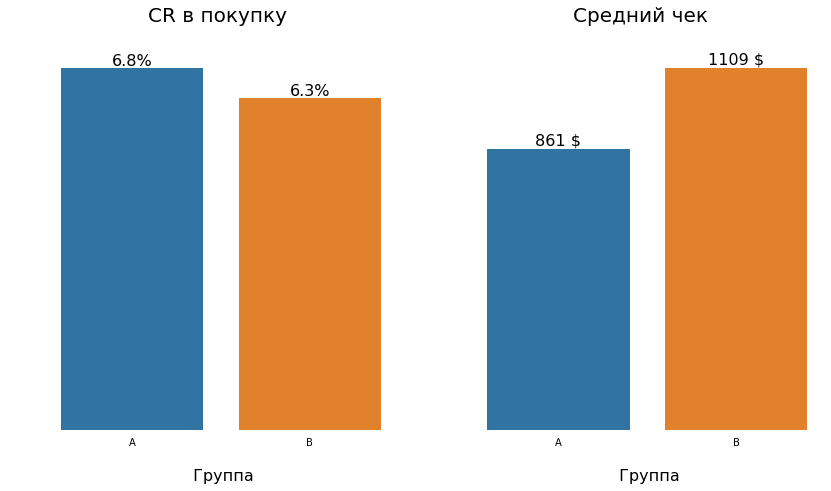

In [ ]:
plot_metrics()